In [1]:
import os
import json
import time
import copy
from copy import deepcopy
from collections import defaultdict

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models

from skimage import io

import matplotlib.pyplot as plt
from matplotlib import patches, patheffects

import imgaug as ia
from imgaug import augmenters as iaa

from sklearn.model_selection import train_test_split

from tqdm import tqdm
from pprint import pprint

In [3]:
from torchsummary import summary

In [4]:
# base_path = r'../input'
base_path = r'input'
PATH_TRAIN_ANNO = os.path.join(base_path, 'train.csv')
PATH_TRAIN_IMG = os.path.join(base_path, 'train')

In [5]:
NUM_CLASSES = 28

In [6]:
IMG_SIZE = 224
BATCH_SIZE = 16
VAL_SIZE =0.33
# DEVICE = torch.device("cpu")
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
THRESHOLD = 0.5

In [8]:
TRAIN_SAMPLE = 0.1

In [9]:
def get_transform_anno(annotation_path, img_path):
    img_map = defaultdict(dict)
    for i in os.listdir(img_path):
        if i.endswith('png'):
            img_id, img_channel = i.split('_')
            img_channel = img_channel.replace(r'.png', '')
            img_map[img_id][img_channel]=i
    
    df = pd.read_csv(annotation_path)
    annotations = []
    for i, row in df.iterrows():
        rcd_id = row['Id']
        rcd_cate =  [int(j) for j in row['Target'].split()]
        rcd_img_path = img_map[rcd_id]
        annotations.append((rcd_id, rcd_cate, rcd_img_path))
    return annotations

In [10]:
#get annotations
annotations_all = get_transform_anno(PATH_TRAIN_ANNO, PATH_TRAIN_IMG)
sample_size = int(len(annotations_all) * TRAIN_SAMPLE)
annotations = annotations_all[:sample_size]
pprint('total size: {} sample size {}'.format(len(annotations_all), sample_size))
pprint(annotations[0])

'total size: 31072 sample size 3107'
('00070df0-bbc3-11e8-b2bc-ac1f6b6435d0',
 [16, 0],
 {'blue': '00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_blue.png',
  'green': '00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_green.png',
  'red': '00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_red.png',
  'yellow': '00070df0-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png'})


In [11]:
MAX_TAGS = 0
for i in annotations_all:
    num_tags = len(i[1])
    if num_tags > MAX_TAGS:
        MAX_TAGS = num_tags
print('max num of tags: {}'.format(MAX_TAGS))

max num of tags: 5


In [12]:
#Test augmentation
seq = iaa.Sequential([
    iaa.Scale({"height": 224, "width": 224}),
    iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Affine(
            rotate=(-20, 20),
        )
    ], random_order=True) # apply augmenters in random order
], random_order=False)

In [13]:
#read raw data
ix = 26
tmp = annotations[ix]
tmp_img_tags = tmp[1]
tmp_img_paths = tmp[2]
tmp_img = [None, None, None, None]
channal_map = {'red': 0, 'blue': 1, 'yellow': 2, 'green': 3}
for k, v in tmp_img_paths.items():
    tmp_img[channal_map[k]] = io.imread(os.path.join(PATH_TRAIN_IMG, v))
tmp_img = np.array(tmp_img)

In [14]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def show_batch_img_per_channel(imgs):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    for ix, ax in enumerate(axes.flat):
        tmp_img = imgs[ix]
        ax = show_img(tmp_img, ax=ax)

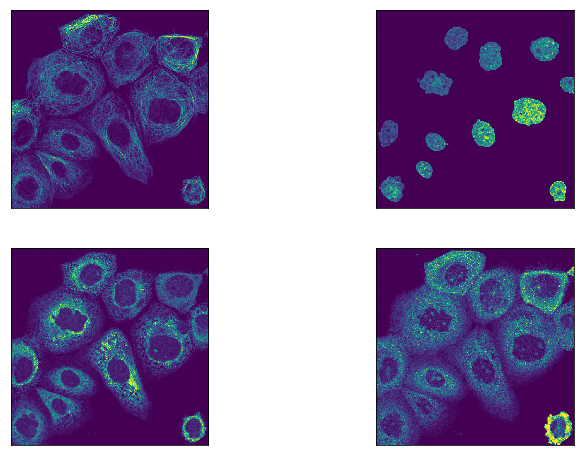

In [15]:
#display each channel before aug
show_batch_img_per_channel(tmp_img)  

In [16]:
seq_det = seq.to_deterministic()

In [17]:
#augmentation
tmp_aug_img=tmp_img.transpose((1, 2, 0))
tmp_aug_img = seq_det.augment_images([tmp_aug_img.copy()])[0]
tmp_aug_img=tmp_aug_img.transpose((2, 1, 0))

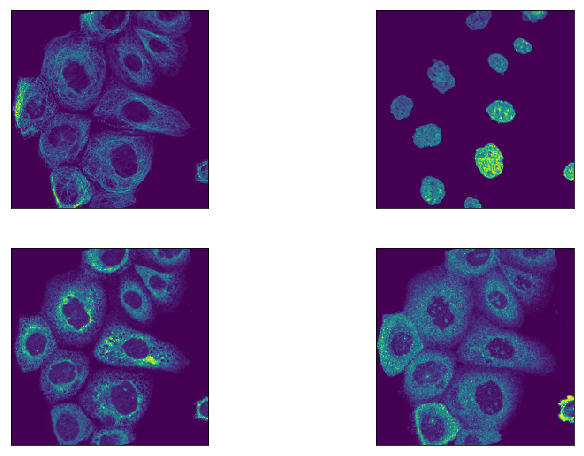

In [18]:
#display each channel after aug
show_batch_img_per_channel(tmp_aug_img)  

In [19]:
class ProteinDataset(Dataset):
    def __init__(self, img_meta, max_tags, transform = None):
        self.img_meta = img_meta
        self.transform = transform
        self.max_tags = max_tags
        self.channel_map = {'red': 0, 'blue': 1, 'yellow': 2, 'green': 3}
        self.dummy_value = 28 #for padding
        
    def __len__(self):
        return len(self.img_meta)
    
    def __getitem__(self, idx):
        _, img_tags, img_paths = self.img_meta[idx]
        img = [None, None, None, None]
        
        for k, v in img_paths.items():
            img[self.channel_map[k]] = io.imread(os.path.join(PATH_TRAIN_IMG, v))
        img = np.array(img)
        #augmentation
        if bool(self.transform) is True:
            img = self.transform(img)
            
        #pad
        img_tags = np.pad(np.array(img_tags), pad_width = (0, self.max_tags), mode = 'constant', constant_values=(self.dummy_value,self.dummy_value))[:self.max_tags]
        
        #transform to tensor
        img = torch.from_numpy(img).float()
        img_tags = torch.from_numpy(img_tags)
        
        output = (img, img_tags)
        return output

In [20]:
class ImgTfm:
    def __init__(self, aug_pipline = None):
        self.seq = aug_pipline
    
    def __call__(self, img):
        
        seq_det = seq.to_deterministic()
        
        #augmentation
        aug_img=img.copy().transpose((1, 2, 0))
        aug_img = seq_det.augment_images([aug_img])[0]
        aug_img=aug_img.transpose((2, 1, 0))
        
        #normalize
        aug_img=aug_img/255
        
        return aug_img

In [21]:
def get_aug_pipline(img_size, mode = 'train'):
    if mode == 'train':
        seq = iaa.Sequential([
            iaa.Scale({"height": IMG_SIZE, "width": IMG_SIZE}),
            iaa.Sequential([
                iaa.Fliplr(0.5),
                iaa.Affine(
                    rotate=(-20, 20),
                )
            ], random_order=True) # apply augmenters in random order
        ], random_order=False)
    else: #ie.val
        seq = iaa.Sequential([
            iaa.Scale({"height": IMG_SIZE, "width": IMG_SIZE}),
        ], random_order=False)
    return seq

In [22]:
train_set, val_set = train_test_split(annotations, test_size=VAL_SIZE, random_state=42)

composed = {}
composed['train'] = transforms.Compose([ImgTfm(aug_pipline=get_aug_pipline(img_size=IMG_SIZE, mode = 'train'))])
composed['val'] = transforms.Compose([ImgTfm(aug_pipline=get_aug_pipline(img_size=IMG_SIZE, mode = 'val'))])

image_datasets = {'train': ProteinDataset(train_set, max_tags = MAX_TAGS, transform=composed['train']),
                 'val': ProteinDataset(val_set, max_tags = MAX_TAGS, transform=composed['val'])}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
              for x in ['train', 'val']}

In [23]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

{'train': 2081, 'val': 1026}


In [24]:
#test dataset
ix = 10
tmp_img, tmp_tags  = image_datasets['train'][ix]

In [25]:
#test dataloader
tmp_img, tmp_tags = next(iter(dataloaders['train']))
print('tmp_img shape: {}\ntmp_tags: shape {}'.format(tmp_img.shape, tmp_tags.shape))

tmp_img shape: torch.Size([16, 4, 224, 224])
tmp_tags: shape torch.Size([16, 5])


In [26]:
def inverse_transform(img_torch):
    """denormalize and inverse transform img"""
#     inv_normalize = transforms.Normalize(
#         mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
#         std=[1/0.229, 1/0.224, 1/0.255]
#     )
    tmp = deepcopy(img_torch)
#     inv_normalize(tmp)
    tmp = np.clip((tmp.numpy().transpose((1,2,0)) * 255), a_min=0, a_max=255).astype(np.int)
    return tmp

In [27]:
def show_batch_img(imgs):
    fig, axes = plt.subplots(3, 4, figsize=(12, 8))
    for ix, ax in enumerate(axes.flat):
        tmp_img = imgs[ix][:3] #showing first 3 channel only
        tmp_img = inverse_transform(tmp_img)
        ax = show_img(tmp_img, ax=ax)

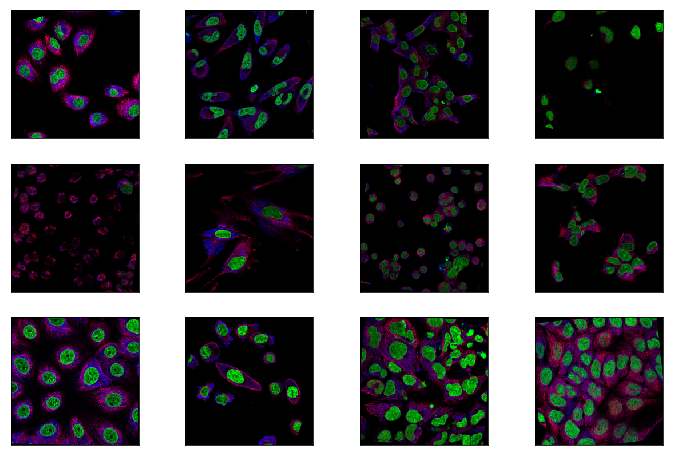

In [28]:
show_batch_img(tmp_img)

In [29]:
class Flatten(nn.Module):
    def __init__(self): 
        super().__init__()
    def forward(self, x): 
        return x.view(x.size(0), -1)

class RnetBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = self._prep_backbone()
        
    def _prep_backbone(self):     
        base_model = models.resnet34(pretrained=False)
        removed = list(base_model.children())[1:-2]
        backbone = nn.Sequential(*removed)
#         for param in backbone.parameters():
#             param.require_grad = False
        return backbone
    
    def forward(self, x):
        x = self.backbone(x)
        return x

class CustomHead(nn.Module):
    def __init__(self, num_class):
        super().__init__()
        self.num_class = num_class
        
        self.flatten = Flatten()
        self.relu_1 = nn.ReLU()
        self.dropout_1 = nn.Dropout(p=0.5)
        self.fc_2 = nn.Linear(512 * 7 * 7, 256)
        self.relu_2 = nn.ReLU()
        self.batchnorm_2 = nn.BatchNorm1d(256)
        self.dropout_2 = nn.Dropout(p=0.5)
        self.fc_3 = nn.Linear(256, self.num_class)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.relu_1(x)
        x = self.dropout_1(x)
        x = self.fc_2(x)
        x = self.relu_2(x)
        x = self.batchnorm_2(x)
        x = self.dropout_2(x)
        x = self.fc_3(x)
        return x

class CustomEntry(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1 = nn.Conv2d(in_channels=4, out_channels=64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    
    def forward(self, x):
        x = self.conv_1(x)
        return x
    
class CustomNet(nn.Module):
    def __init__(self, num_class):
        super().__init__()
        self.custom_entry = CustomEntry()
        self.backbone = RnetBackbone()
        self.custom_head = CustomHead(num_class)
        
    def forward(self, x):
        x = self.custom_entry(x)
        x = self.backbone(x)
        x = self.custom_head(x)
        return x

In [30]:
def k_hot_embedding(labels, num_classes):
    khot = torch.eye(num_classes)[labels.data.cpu()]
    khot = khot.sum(1).clamp(0,1)
    return khot

def prep_yTrue(y_true):
    #prep y_true
    y_true_khot = k_hot_embedding(y_true, num_classes = NUM_CLASSES + 1)
    y_true_khot = y_true_khot[:, :-1] #last element is dummy
    y_true_khot = y_true_khot.to(DEVICE)
    return y_true_khot

def criterion(y_pred, y_true):
    y_true_khot = prep_yTrue(y_true)
    
    #calculate loss
    loss = F.binary_cross_entropy_with_logits(y_pred, y_true_khot)
    return loss

In [31]:
def calc_batch_stats(y_pred, y_true):
    #prep y_pred and y_true
    y_true_khot = prep_yTrue(y_true).byte()
    y_pred_sgmd = torch.sigmoid(y_pred) > THRESHOLD
    
    #calc batch stats
    batch_true_pos = (y_pred_sgmd * y_true_khot).sum(0)
    batch_false_pos = y_pred_sgmd.sum(0) - batch_true_pos
    batch_false_neg = y_true_khot.sum(0) - batch_true_pos
    
    batch_true_pos = batch_true_pos.cpu().numpy()
    batch_false_pos = batch_false_pos.cpu().numpy()
    batch_false_neg = batch_false_neg.cpu().numpy()
    
    return batch_true_pos, batch_false_pos, batch_false_neg

In [36]:
def calc_epoch_stats(running_true_pos, running_false_pos, running_false_neg):
    #per class stats
    percision_per_class = np.nan_to_num(running_true_pos/(running_true_pos+running_false_pos),0)
    recall_per_class= np.nan_to_num(running_true_pos/(running_true_pos+running_false_neg),0)
    f1_per_class = np.nan_to_num((2 * (percision_per_class * recall_per_class)/(percision_per_class + recall_per_class)),0)
    
    #calc macro scores
    percision_macro = np.mean(percision_per_class)
    recall_macro = np.mean(recall_per_class)
    f1_macro = np.mean(f1_per_class)
    
    return percision_macro, recall_macro, f1_macro

In [33]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            #initialize running stats
            running_loss = 0.0
            running_true_pos = np.zeros(shape = NUM_CLASSES)
            running_false_pos = np.zeros(shape = NUM_CLASSES)
            running_false_neg = np.zeros(shape = NUM_CLASSES)

            # Iterate over data.
            for inputs, targets in dataloaders[phase]:
                inputs = inputs.to(DEVICE)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                batch_true_pos, batch_false_pos, batch_false_neg = calc_batch_stats(outputs, targets)
                running_true_pos += batch_true_pos
                running_false_pos += batch_false_pos
                running_false_neg += batch_false_neg
                
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_percision, epoch_recall, epoch_f1 = calc_epoch_stats(running_true_pos, running_false_pos, running_false_neg)
    
            print('{} Loss: {:.4f} Percision: {:.4f} Recall: {:.4f} F1: {:.4f}'.format(
                phase, epoch_loss, epoch_percision, epoch_recall, epoch_f1))

            # deep copy the model
            if phase == 'val' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val F1: {:4f}'.format(best_f1))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [34]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = CustomNet(num_class=NUM_CLASSES)
model_ft = model_ft.to(DEVICE)

# criterion = nn.MSELoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [37]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 0.6913 Percision: 0.0611 Recall: 0.4459 F1: 0.0899


/home/spacor/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/home/spacor/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


val Loss: 0.6721 Percision: 0.0651 Recall: 0.3521 F1: 0.0883

Epoch 1/4
----------
train Loss: 0.6774 Percision: 0.0617 Recall: 0.4090 F1: 0.0896
val Loss: 0.6586 Percision: 0.0649 Recall: 0.2865 F1: 0.0873

Epoch 2/4
----------
train Loss: 0.6645 Percision: 0.0630 Recall: 0.3940 F1: 0.0903
val Loss: 0.6457 Percision: 0.0657 Recall: 0.1677 F1: 0.0833

Epoch 3/4
----------
train Loss: 0.6525 Percision: 0.0608 Recall: 0.2955 F1: 0.0845
val Loss: 0.6354 Percision: 0.0654 Recall: 0.1601 F1: 0.0783

Epoch 4/4
----------
train Loss: 0.6400 Percision: 0.0639 Recall: 0.2836 F1: 0.0886
val Loss: 0.6226 Percision: 0.0690 Recall: 0.1111 F1: 0.0746

Training complete in 2m 60s
Best val F1: 0.088295


In [ ]:
# #test feed 1 batch

# # tmp_img, tmp_tags =

# tmp_img = tmp_img.to(DEVICE)
# tmp_y_pred = model_ft(tmp_img)

# tmp_y_true = prep_yTrue(tmp_tags).byte()

# tmp_y_pred_sgmd = torch.sigmoid(tmp_y_pred) > THRESHOLD

# tmp_y_pred_sgmd.shape

# tmp_y_true.shape

# batch_true_pos = (tmp_y_pred_sgmd * tmp_y_true).sum(0)
# batch_false_pos = tmp_y_pred_sgmd.sum(0) - batch_true_pos
# batch_false_neg = tmp_y_true.sum(0) - batch_true_pos

# batch_true_pos.shape

# running_true_pos = np.zeros(shape = NUM_CLASSES)
# running_false_pos = np.zeros(shape = NUM_CLASSES)
# running_false_neg = np.zeros(shape = NUM_CLASSES)

# tmp_tags.dtype

# batch_true_pos, batch_false_pos, batch_false_neg = calc_batch_stats(tmp_y_pred, tmp_tags)

# running_true_pos += batch_true_pos
# running_false_pos += batch_false_pos
# running_false_neg += batch_false_neg

# running_true_pos

# running_false_pos

# running_false_neg

# percision_per_class = np.nan_to_num(running_true_pos/(running_true_pos+running_false_pos),0)

# recall_per_class= np.nan_to_num(running_true_pos/(running_true_pos+running_false_neg),0)

# f1_per_class = np.nan_to_num((2 * (percision_macro * recall_macro)/(percision_macro + recall_macro)),0)

# f1_macro = np.mean(f1_per_class)
# f1_macro

# recall_macro = np.mean(recall_per_class)
# recall_macro

# percision_macro = np.mean(percision_per_class)
# percision_macro

In [40]:
a = dataloaders['train']

In [44]:
len(a.dataset)

2081